In [124]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt  
import yfinance as yf 
from datetime import datetime, timedelta

from sklearn.covariance import LedoitWolf

In [ ]:
np.random.seed()

# 1. Markowitz et frontière efficiente en théorie

In [149]:
# extraction des données

class FinancialData():

    def __init__(self, tickers_csv_path, num_tickers):
        self.tickers_csv_path = tickers_csv_path
        if isinstance(num_tickers, int):
            num_tickers = list(range(num_tickers)) 
        self.num_tickers = num_tickers
        self.tickers = None
        self.data_clean = None
        self.mu = None
        self.Sigma = None

    def extract_tickers(self):
        tickers_df = pd.read_csv(self.tickers_csv_path)
        list_tickers = tickers_df.loc[self.num_tickers, 'Ticker'].tolist()
        self.tickers = list_tickers
    
    def get_returns(self, start, end, period="1d"):
        data = yf.download(self.tickers, start=start, end=end, period=period)['Adj Close']
        data = data.pct_change(fill_method=None).dropna()
        data.index = data.index.strftime("%Y-%m-%d")
        self.data_clean = data

    def calculate_statistics(self):
        if self.data_clean is not None:
            self.mu = self.data_clean.mean(axis=0).values
            self.Sigma = self.data_clean.cov(rowvar=True).to_numpy()
        else:
            print("get returns before please")


In [158]:
# envisager de coder un truc qui gere des lambdas de plusieurs tailles 

def get_markowitz_weights(lam, mu, Sigma):
    Sigma_inv = np.linalg.inv(Sigma)
    n = len(mu)
    e = np.ones(n)

    eT_Sigma_inv_e = e.T @ Sigma_inv @ e
    eT_Sigma_inv_mu = e.T @ Sigma_inv @ mu

    term1 = Sigma_inv @ e / eT_Sigma_inv_e
    
    adjusted_mu = Sigma_inv @ mu - (eT_Sigma_inv_mu / eT_Sigma_inv_e) * (Sigma_inv @ e)
    term2 = (1 / lam) * adjusted_mu
    w_star = term1 + term2
    return w_star

def portfolio_performance(weights, mean_returns, cov_matrix):
    rendement_portefeuille = np.dot(weights, mean_returns)
    variance_portefeuille = np.dot(weights.T, np.dot(cov_matrix, weights))
    risque_portefeuille = np.sqrt(variance_portefeuille)
    return rendement_portefeuille, risque_portefeuille



In [93]:
# input 

tickers_csv_path = "C:\\Users\\Nicola\\clones_github\\DL-Portfolio-CMAP\\data\\S&P 500 tickers.csv"
num_tickers = 5 # doit etre au minimum 2 
end = datetime.today()
start = end - timedelta(days=365.25*20)

In [94]:
# output

data_extractor_5 = FinancialData(tickers_csv_path, num_tickers)
data_extractor_5.extract_tickers()
data_extractor_5.get_returns(start=start, end=end)
data_extractor_5.calculate_statistics()
rets_df = data_extractor_5.data_clean
mu_5 = data_extractor_5.mu
Sigma_5 = data_extractor_5.Sigma

rets_df.head()

[*********************100%***********************]  5 of 5 completed


Ticker,ABBV,ABT,ACN,AOS,MMM
Date,,,,,
2013-01-03,-0.008257,0.038066,-0.003620,-0.015632,-0.001160
2013-01-04,-0.012633,-0.006012,0.005522,0.010849,0.007394
2013-01-07,0.002036,0.008164,-0.004336,-0.011044,0.001258
2013-01-08,-0.021764,0.000300,0.005806,0.019031,0.000105
2013-01-09,0.005636,0.006597,0.007072,-0.006483,0.009529


Text(0, 0.5, 'mean')

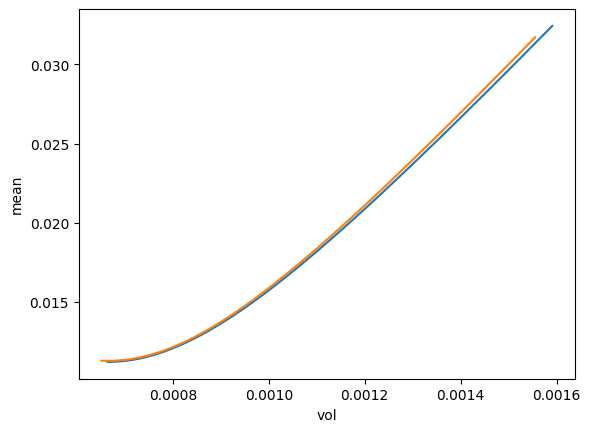

In [160]:
# calcul de la moyenne et de l'écart type des rendements des portefeuilles efficients pour difféérents coefficients d'aversion au risque 

n_lambdas = 1000
lambdas = np.logspace(0,6, n_lambdas)
weights = np.array(list(map(lambda lam: get_markowitz_weights(lam, mu_5, Sigma_5), lambdas)))




mu_port = np.array(list(map(lambda weight: portfolio_performance(weights=weight, mean_returns=mu_5, cov_matrix=Sigma_5)[0], weights)))
sigma_port = np.array(list(map(lambda weight: portfolio_performance(weights=weight, mean_returns=mu_5, cov_matrix=Sigma_5)[1], weights)))



plt.plot(mu_port, sigma_port)

plt.xlabel("vol")
plt.ylabel("mean")

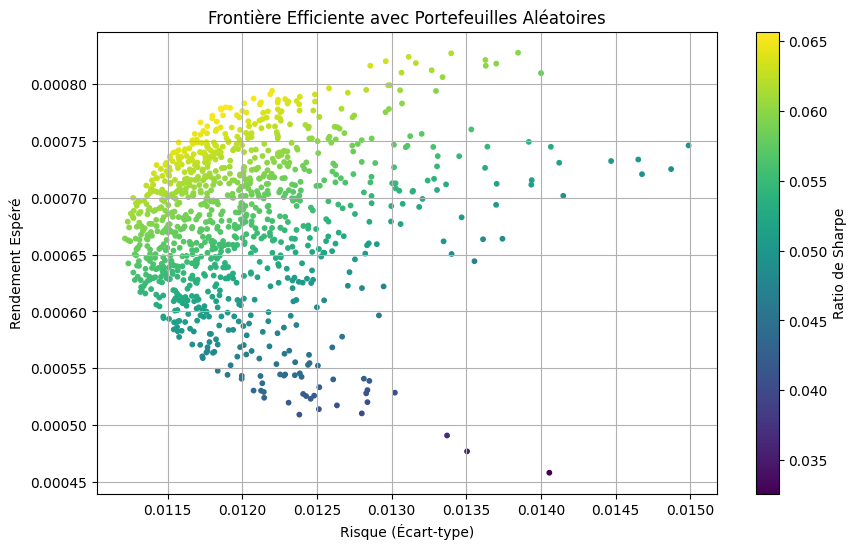

In [96]:
# tirer des portefeuilles aléatoires 

n_samples=1000
random_weights = np.random.dirichlet(np.ones(num_tickers), size=n_samples)

mu_random = random_weights @ mu_5
sigma_squared_random = random_weights @ Sigma_5 @ random_weights.T #simplifier ? 
sigma_random = np.sqrt(np.diag(sigma_squared_random))
sharpe_random = mu_random / sigma_random

plt.figure(figsize=(10, 6))
plt.scatter(sigma_random, mu_random, c=sharpe_random, cmap='viridis', marker='o', s=10)
plt.title('Frontière Efficiente avec Portefeuilles Aléatoires')
plt.xlabel('Risque (Écart-type)')
plt.ylabel('Rendement Espéré')
plt.colorbar(label='Ratio de Sharpe')
plt.grid()
plt.show()


# 2. Markowitz et frontière efficiente en pratique 

In [143]:
n_samples = 250
dim = 5 

X = np.random.normal(loc=0, scale=1, size=(n_samples, dim))
R = np.linalg.cholesky(Sigma_5)

mu_temp = mu_5[:, np.newaxis]


Y = R @ X.T + np.hstack([mu_temp] * n_samples) 

cov_hat_Y = np.cov(Y, rowvar=True)
cov_hat_Y

array([[3.03943893e-04, 1.07238768e-04, 7.73889123e-05, 7.07780455e-05,
        8.43597841e-05],
       [1.07238768e-04, 2.09319147e-04, 1.06179717e-04, 7.08838260e-05,
        8.35274479e-05],
       [7.73889123e-05, 1.06179717e-04, 1.92325417e-04, 9.64842052e-05,
        1.14552003e-04],
       [7.07780455e-05, 7.08838260e-05, 9.64842052e-05, 2.65513719e-04,
        1.21836057e-04],
       [8.43597841e-05, 8.35274479e-05, 1.14552003e-04, 1.21836057e-04,
        2.13355115e-04]])

In [144]:
Y = np.random.multivariate_normal(mean=mu_5, cov=Sigma_5, size=250)

cov_hat_Y = np.cov(Y, rowvar=False) 
cov_hat_Y

array([[3.28628300e-04, 1.30811459e-04, 1.05022244e-04, 7.15454609e-05,
        9.09266400e-05],
       [1.30811459e-04, 2.26602335e-04, 1.20465657e-04, 1.09408046e-04,
        1.05909077e-04],
       [1.05022244e-04, 1.20465657e-04, 2.31516540e-04, 1.21799321e-04,
        9.68802671e-05],
       [7.15454609e-05, 1.09408046e-04, 1.21799321e-04, 2.71257103e-04,
        1.30825910e-04],
       [9.09266400e-05, 1.05909077e-04, 9.68802671e-05, 1.30825910e-04,
        2.18931307e-04]])

In [145]:
np.linalg.norm(cov_hat_Y - Sigma_5)

9.169266729451301e-05

In [146]:
cov_LW = LedoitWolf()
cov_LW.fit(Y)
cov_LW.covariance_

array([[3.24850792e-04, 1.25889212e-04, 1.01070408e-04, 6.88533082e-05,
        8.75052014e-05],
       [1.25889212e-04, 2.26663916e-04, 1.15932708e-04, 1.05291179e-04,
        1.01923871e-04],
       [1.01070408e-04, 1.15932708e-04, 2.31393207e-04, 1.17216188e-04,
        9.32348020e-05],
       [6.88533082e-05, 1.05291179e-04, 1.17216188e-04, 2.69638390e-04,
        1.25903119e-04],
       [8.75052014e-05, 1.01923871e-04, 9.32348020e-05, 1.25903119e-04,
        2.19281538e-04]])

In [147]:
Sigma_5

array([[2.71104235e-04, 1.03335605e-04, 8.55850792e-05, 7.56816185e-05,
        7.83889257e-05],
       [1.03335605e-04, 2.05762420e-04, 1.12237549e-04, 8.74930080e-05,
        8.96024534e-05],
       [8.55850792e-05, 1.12237549e-04, 2.25961322e-04, 1.15172305e-04,
        1.06538637e-04],
       [7.56816185e-05, 8.74930080e-05, 1.15172305e-04, 2.78525594e-04,
        1.25350099e-04],
       [7.83889257e-05, 8.96024534e-05, 1.06538637e-04, 1.25350099e-04,
        2.21017577e-04]])

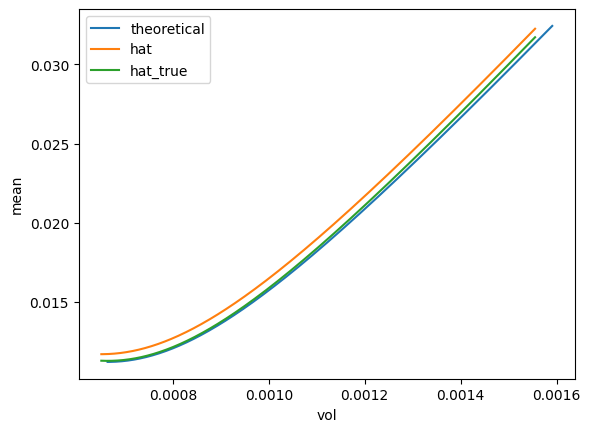

In [163]:
weights_hat = np.array(list(map(lambda lam: get_markowitz_weights(lam, mu_5, cov_hat_Y), lambdas)))

mu_port_hat = np.array(list(map(lambda weight: portfolio_performance(weights=weight, mean_returns=mu_5, cov_matrix=cov_hat_Y)[0], weights_hat)))
sigma_random_hat = np.array(list(map(lambda weight: portfolio_performance(weights=weight, mean_returns=mu_5, cov_matrix=cov_hat_Y)[1], weights_hat)))

mu_port_hat_true = np.array(list(map(lambda weight: portfolio_performance(weights=weight, mean_returns=mu_5, cov_matrix=Sigma_5)[0], weights_hat)))
sigma_random_hat_true = np.array(list(map(lambda weight: portfolio_performance(weights=weight, mean_returns=mu_5, cov_matrix=Sigma_5)[1], weights_hat)))


plt.plot(mu_port, sigma_port, label='theoretical')
plt.plot(mu_port_hat, sigma_random_hat, label='hat')
plt.plot(mu_port_hat_true, sigma_random_hat_true, label='hat_true')

plt.xlabel("vol")
plt.ylabel("mean")
plt.legend()